In [1]:
# Adapted from code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import join,isfile
import time
import numpy as np
%matplotlib inline

In [2]:
# !unzip Dataset_v4_2.zip #extract it to the current directory. In Dataset_v4_2.zip, .DS_Store files are removed

# Set Hyperparameters and load data

In [3]:
# Set Hyperparameters

epoch = 20
batch_size = 5 # 100 will result in "out of memory" error
learning_rate = 0.001 # for training autoencoder

num_neuron_layer=1000 # number of neurons in each fully connected layer
learning_rate_2 = 0.002 # for training FC
momentum=0.9 # for training FC

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download Data
soccer_train = dset.ImageFolder(os.path.join('Dataset_v4', 'train'),data_transforms['train'])
soccer_test = dset.ImageFolder(os.path.join('Dataset_v4', 'val'),data_transforms['val'])

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=soccer_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=soccer_test,batch_size=batch_size,shuffle=True)

# Train denoising autoencoder
### Encoder Model 1: small
The model used for training with CIFAR

In [4]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,5,padding=2),   # batch x 32 x 224 x 224
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 224 x 224
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 224 x 224
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 224 x 224
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 112 x 112
                        
                        
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 112 x 112
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 112 x 112
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),  # batch x 128 x 8 x 8
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 56 x 56
                        nn.ReLU()
        )

        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 256*56*56)
        return out
    


### Encoder Model 2: middle

In [5]:
# # Encoder 
# # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
# #                 stride=1, padding=0, dilation=1,
# #                 groups=1, bias=True)

# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder,self).__init__()
#         self.layer1 = nn.Sequential(
#                         nn.Conv2d(3,64,3,padding=1),   # batch x 64 x 224 x 224
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#                         nn.Conv2d(64,64,3,padding=1),   # batch x 64 x 224 x 224
#                         nn.ReLU(),
#                         nn.BatchNorm2d(64),
#                         nn.MaxPool2d(2),   # batch x 64 x 112 x 112
#                         nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 112 x 112
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 112 x 112
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.MaxPool2d(2)   # batch x 128 x 56 x 56

                        
#         )
#         self.layer2 = nn.Sequential(
#                         nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 56 x 56
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.Conv2d(256,256,3,padding=1),  # batch x 256 x 56 x 56
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.MaxPool2d(2),  # batch x 128 x 28 x 28
#                         nn.Conv2d(256,512,3,padding=1),  # batch x 512 x 28 x 28
#                         nn.ReLU()
#         )

        
                
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(-1, 512*28*28)
#         return out
    

### Encoder Model 3: big
In order to preserve more information in the first layers I used more filters

In [6]:
# # Encoder 
# # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
# #                 stride=1, padding=0, dilation=1,
# #                 groups=1, bias=True)

# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder,self).__init__()
#         self.layer1 = nn.Sequential(
#                         nn.Conv2d(3,256,5,padding=2),   # batch x 256 x 224 x 224
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.Conv2d(256,256,5,padding=2),   # batch x 256 x 224 x 224
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.MaxPool2d(2),   # batch x 32 x 112 x 112

#                         nn.Conv2d(256,128,5,padding=2),  # batch x 128 x 112 x 112
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.Conv2d(128,128,5,padding=2),  # batch x 128 x 112 x 112
#                         nn.ReLU(),
#                         nn.BatchNorm2d(128),
#                         nn.MaxPool2d(2)   # batch x 64 x 56 x 56
#         )
#         self.layer2 = nn.Sequential(
#                         nn.Conv2d(128,256,3,padding=1),  # batch x 128 x 56 x 56
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.Conv2d(256,256,3,padding=1),  # batch x 256 x 56 x 56
#                         nn.ReLU(),
#                         nn.BatchNorm2d(256),
#                         nn.MaxPool2d(2),  # batch x 128 x 28 x 28
#                         nn.Conv2d(256,512,3,padding=1),  # batch x 512 x 28 x 28
#                         nn.ReLU()
#         )

        
                
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(-1, 512*28*28)
#         return out
    


### Decoder

In [7]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# The kernel_size, stride, padding here are the values used in convolution
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# Above equation is the inverse process of the one in convolution (except the output_padding part): 
# output_height=(input_height + 2∗padding - kernel_size) / stride + 1 (should round down to an integer)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), # stride=2 because of pooling in convolution
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1), # no output padding  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,5,1,2), # Why is this the last step of layer2? What if I put it in the first step of layer2?
                        nn.ReLU()
        )

        
    def forward(self,x):
        out = x.view(-1,256,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out



### Initialize model, image noise, loss function and optimizer

In [9]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()
    

In [8]:
noise = torch.randn(batch_size,3,224,224)*0.5 # normal distribution of mean=0, std=1

<class 'int'>


In [11]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
loss_func = nn.MSELoss().cuda()

### Check output of autoencoder

Input image:  (5, 3, 224, 224)


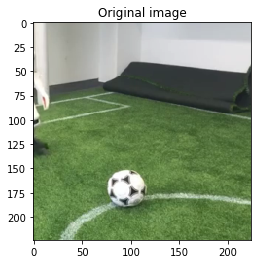

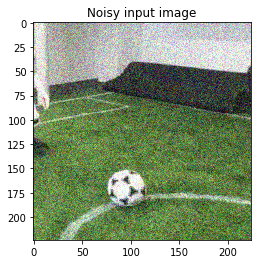

Hidden layer output: (5, 802816)


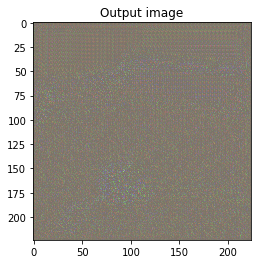

Final output: torch.Size([5, 3, 224, 224])


In [10]:
def img_show(img_tsr,title): # img_tsr: image tensor
    mean=np.array([0.485, 0.456, 0.406])
    sd=np.array([0.229, 0.224, 0.225])
    img=img_tsr.numpy().transpose((1,2,0))*sd+mean
    img=np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
for image,label in train_loader:
    
    print("Input image: ",image.numpy().shape)
    img_show(image[0],'Original image')
    
    n_image=image[0]+noise[0]
    img_show(n_image,'Noisy input image')
    
    image = Variable(image).cuda()    
    output = encoder(image)
    print("Hidden layer output:", output.cpu().data.numpy().shape)
    output = decoder(output)
    img_show(output.cpu().data[0],'Output image')
    print("Final output:",output.size())
    break


In [ ]:
# del encoder
# del decoder
# del optimizer
# # Free memory

### Train encoder and decoder

In [12]:
since = time.time()
loss_vec_train=[] # average training loss of each epoch
loss_vec_test=[] # average test loss of each epoch


for i in range(epoch):
    encoder.train() # set the models to train mode
    decoder.train()
    print("Epoch {}:".format(i+1))
    num_iter=0 # index of iteration in each epoch
    epoch_loss=0
    for image,label in train_loader:
        num_iter+=1
        if image.size()[0]!=batch_size: # if the last batch is not full
            image_n = image+noise[0:(image.size()[0])] # add Gaussian noise to original image
        else: image_n = image+noise # add Gaussian noise to original image
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.data[0]
        if num_iter%10==0:
            print("MSE Loss: {:.4f} * 1e-03  [{}/{} ({:.0f}%)]"
                  .format(loss.data[0]*1000,num_iter*batch_size,len(train_loader)*batch_size,num_iter/len(train_loader)*100))
            
    # record loss change
    epoch_loss/=len(train_loader)
    loss_vec_train.append(epoch_loss) # Add the average loss of this epoch
    time_elapsed = time.time() - since
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    
    # test on test dataset
    encoder.eval() # set the models to evaluation mode
    decoder.eval()
    test_loss=0
    for image,label in test_loader:
#         print(image.size())
#         print(noise.size())
        if image.size()[0]!=batch_size: # if the last batch is not full
            image_n = image+noise[0:(image.size()[0])] # add Gaussian noise to original image
        else: image_n = image+noise # add Gaussian noise to original image
        image = Variable(image, volatile=True).cuda()  # volatile=True is more efficient when you won’t call .backward()
        image_n = Variable(image_n, volatile=True).cuda()
        #label = Variable(label.float()).cuda()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        test_loss+=loss.data[0]
    
    print("Average test MSE Loss: {:.4f} * 1e-03".format(test_loss/len(test_loader)*1000))   
    loss_vec_test.append(test_loss/len(test_loader))
    time_elapsed = time.time() - since # Add the average test loss of this epoch
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
          
# record time                
print("Final MSE Loss: {}".format(loss.data[0]))


Epoch 1:
MSE Loss: 591.7402 * 1e-03  [50/395 (13%)]
MSE Loss: 669.4632 * 1e-03  [100/395 (25%)]
MSE Loss: 1106.6355 * 1e-03  [150/395 (38%)]
MSE Loss: 644.4317 * 1e-03  [200/395 (51%)]
MSE Loss: 467.8418 * 1e-03  [250/395 (63%)]
MSE Loss: 620.3732 * 1e-03  [300/395 (76%)]
MSE Loss: 701.0553 * 1e-03  [350/395 (89%)]
Time elapsed: 0m 47s

Average test MSE Loss: 1173.8955 * 1e-03
Time elapsed: 0m 56s

Epoch 2:
MSE Loss: 561.1777 * 1e-03  [50/395 (13%)]
MSE Loss: 756.1337 * 1e-03  [100/395 (25%)]
MSE Loss: 964.3865 * 1e-03  [150/395 (38%)]
MSE Loss: 581.2815 * 1e-03  [200/395 (51%)]
MSE Loss: 1130.8450 * 1e-03  [250/395 (63%)]
MSE Loss: 622.4152 * 1e-03  [300/395 (76%)]
MSE Loss: 676.4897 * 1e-03  [350/395 (89%)]
Time elapsed: 1m 44s

Average test MSE Loss: 1165.7503 * 1e-03
Time elapsed: 1m 53s

Epoch 3:
MSE Loss: 485.6781 * 1e-03  [50/395 (13%)]
MSE Loss: 532.6695 * 1e-03  [100/395 (25%)]
MSE Loss: 743.7359 * 1e-03  [150/395 (38%)]
MSE Loss: 747.9231 * 1e-03  [200/395 (51%)]
MSE Loss: 92

### Plot training and test loss

[0.7537697183934948, 0.68707748757133, 0.6785421182837668, 0.6794829300687283, 0.6735774240916288, 0.6672225960447818, 0.6641524219060246, 0.6669225922868222, 0.6679548673991915, 0.6614774782446367, 0.6582555589796621, 0.6602713314792777, 0.6560712796223315, 0.6556969541537611, 0.6555001169820375, 0.652645185401168, 0.6506158034258251, 0.6493305484705334, 0.6533295666869683, 0.6500355771070794]


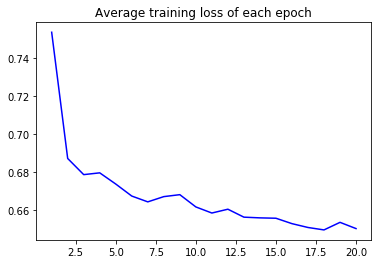

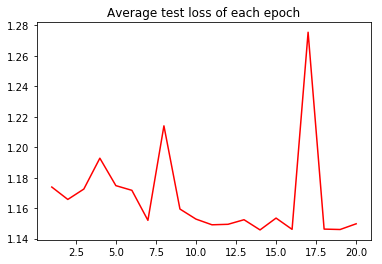

In [13]:
print(loss_vec_train)

plt.plot(np.arange(1,epoch+1),loss_vec_train, 'b') #visualize loss change
plt.title('Average training loss of each epoch')
plt.show()

plt.plot(np.arange(1,epoch+1),loss_vec_test, 'r') #visualize loss change
plt.title('Average test loss of each epoch')
plt.show()

### Check output image

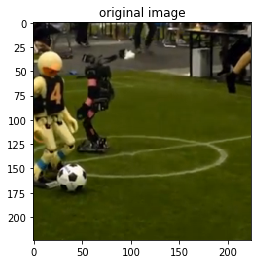

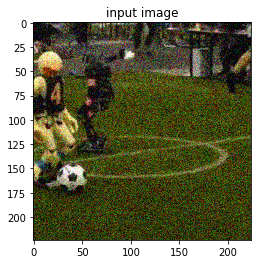

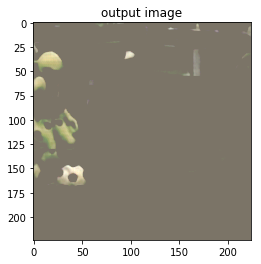

1


In [17]:
img_show(image[3].cpu().data,"original image")

img_show(image_n[3].cpu().data,"input image")

img_show(output[3].cpu().data,"output image")

print(label[3])

### Save model

In [14]:
# if not os.path.exists('./model'):
#     os.mkdir('./model')
# torch.save([encoder,decoder],'./model/deno_autoencoder_soccer_small.pkl')

/home/local/stud/zhaoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/local/stud/zhaoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Use the latent space of trained encoder to do classification 
### Loading stored encoder, and fix its parameters

In [9]:
try:
    encoder, decoder = torch.load('./model/deno_autoencoder_soccer_small.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

del decoder # decoder will not be used

for param in encoder.parameters():
    param.requires_grad = False # do not change the weights in the encoder layers
encoder.cuda()



--------model restored--------



Encoder(
  (layer1): Sequential(
    (0): Conv2d (3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (6): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (9): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Re

### Fully connected layer to be concatenated to encoder

In [10]:
# Fully connected layer concatenated to encoder
class FC(nn.Module):
    def __init__(self):
        super(FC,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Linear(256*56*56,num_neuron_layer), # hidden layer 1
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 2
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 3
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 4
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,2), # hidden layer 5
        )
        
        
    def forward(self,x):
        out = x.view(batch_size,-1)
        out = self.layer1(out)
        return out



### Initialize fully connected layer, classification loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss().cuda()

In [13]:
fc_layers=FC().cuda() # should reinitialize every time when changing the optimizer!!
parameters_2 = fc_layers.parameters()
optimizer_2 = torch.optim.Adam(parameters_2, lr=0.001)
# optimizer_2 = torch.optim.SGD(parameters_2, lr=learning_rate_2, momentum=momentum)
# optimizer_2 = torch.optim.Adadelta(parameters_2) # lr=learning_rate_2. Default lr of Adadelta is 1.0

### Concatenate encoder and fc and train fc

In [15]:
since = time.time()
acc_vec_train=[] # average training accuracy of each epoch
acc_vec_test=[] # average test accuracy of each epoch
best_acc=0.0

for i in range(epoch):
    encoder.train() # set the models to train mode
    fc_layers.train()
    print("Epoch {}:".format(i+1))
    num_iter=0 # index of iteration in each epoch
    epoch_acc=0 # average accuracy of epoch
    train_acc=0 # training accuracy of this epoch
    for image,label in train_loader:
        num_iter+=1
        if image.size()[0]!=batch_size: # if the last batch is not full
            image_n = image+noise[0:(image.size()[0])] # add Gaussian noise to original image
        else: image_n = image+noise # add Gaussian noise to original image
        # image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        label = Variable(label).cuda()
        optimizer_2.zero_grad()
        output = encoder(image_n)
        output = fc_layers(output)
#         print(label)
#         print(output)
        loss = criterion(output,label)
        print(loss)
        loss.backward()
        optimizer_2.step()
        
        pred = output.data.max(1)[1] # pred is a vector of indices of row-wise max of output
        correct = pred.eq(label.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size
        train_acc+=accuracy
        
        if num_iter%250==0:
            print("Loss: {:.4f}  [{}/{} ({:.0f}%)]"
                  .format(loss.data[0],num_iter*batch_size,len(train_loader)*batch_size,num_iter/len(train_loader)*100))
    
    print("Average training accuracy: {:.2f}%".format(train_acc/len(train_loader))) 
    acc_vec_train.append(train_acc/len(train_loader))            
    # record loss change
    time_elapsed = time.time() - since
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    
    # test on test dataset
    encoder.eval() # set the models to evaluation mode
    fc_layers.eval()
    test_acc=0 # test acc of this epoch
    for image,label in test_loader:
        if image.size()[0]!=batch_size: # if the last batch is not full
            image_n = image+noise[0:(image.size()[0])] # add Gaussian noise to original image
        else: image_n = image+noise # add Gaussian noise to original image        # image = Variable(image, volatile=True).cuda()  # volatile=True is more efficient when you won’t call .backward()
        image_n = Variable(image_n, volatile=True).cuda()
        label = Variable(label).cuda()
        output = encoder(image_n)
        output = fc_layers(output)
        loss = criterion(output,label)
        
        pred = output.data.max(1)[1] # pred is a vector of indices of row-wise max of output
        correct = pred.eq(label.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size
        test_acc+=accuracy
    epoch_test_acc=test_acc/len(test_loader)
    if epoch_test_acc>best_acc: #update the best model
        best_acc = epoch_test_acc
        best_model_wts = fc_layers.state_dict()
    print("Average test accuracy: {:.2f}%".format(epoch_test_acc))   
    acc_vec_test.append(epoch_test_acc)

    time_elapsed = time.time() - since # Add the average test loss of this epoch
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    

Epoch 1:
Variable containing:
 0.6867
[torch.cuda.FloatTensor of size 1 (GPU 0)]



RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCTensorMath.cu:35

### Plot training and test loss

In [ ]:
plt.plot(np.arange(1,epoch+1),acc_vec_train, 'b') #visualize loss change
plt.title('Average training accuracy of each epoch')
plt.show()

plt.plot(np.arange(1,epoch+1),acc_vec_test, 'r') #visualize loss change
plt.title('Average test accuracy of each epoch')
plt.show()

### Save the best model parameters

In [ ]:
torch.save(best_model_wts, "deno_autoencoder_fc_soccer_best") # save with name of the corresponding autoencoder + "_fc"